In [3]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Fashion-MNIST veri setini yükle
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Veriyi düzleştir ve Min-Max Normalizasyonu uygula (0-1 aralığına çek)
x_train_flat = x_train.reshape(-1, 28 * 28) / 255.0
x_test_flat = x_test.reshape(-1, 28 * 28) / 255.0

# Eğitim ve doğrulama veri setini ayır
x_train, x_val, y_train, y_val = train_test_split(x_train_flat, y_train, test_size=0.2, random_state=42)

# Sınıf etiketlerini kategorik hale getir
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [4]:
# MLP modelini tanımlayan fonksiyon
def create_mlp_model(layer_sizes, learning_rate):
    model = Sequential()
    model.add(Dense(layer_sizes[0], input_dim=x_train.shape[1], activation='relu'))
    for size in layer_sizes[1:]:
        model.add(Dense(size, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hiperparametre denemeleri
param_grid = {
    'layer_sizes': [[64], [128, 64]],
    'learning_rate': [0.001, 0.01]
}

best_accuracy = 0
best_params = None
best_model = None

# Tüm kombinasyonları dene
for layer_sizes in param_grid['layer_sizes']:
    for learning_rate in param_grid['learning_rate']:
        model = create_mlp_model(layer_sizes, learning_rate)
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=64, verbose=0)
        _, val_accuracy = model.evaluate(x_val, y_val, verbose=0)

        print(f"Params: {layer_sizes}, LR: {learning_rate} -> Val Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = (layer_sizes, learning_rate)
            best_model = model

print(f"Best Params: {best_params} -> Best Val Accuracy: {best_accuracy:.4f}")

C:\Users\besir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params: [64], LR: 0.001 -> Val Accuracy: 0.8698
Params: [64], LR: 0.01 -> Val Accuracy: 0.8658
Params: [128, 64], LR: 0.001 -> Val Accuracy: 0.8758
Params: [128, 64], LR: 0.01 -> Val Accuracy: 0.8533
Best Params: ([128, 64], 0.001) -> Best Val Accuracy: 0.8758


Test Accuracy: 0.8725
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
 [[867   0  22  45   2   1  54   0   9   0]
 [  3 966   1  24   2   0   1   0   2   1]
 [ 18   1 856  13  86   0  21   0   5   0]
 [ 26   4  16 903  33   1  14   0   3   0]
 [  0   1 154  29 785   0  27   0   4   0]
 [  0   0   0   0   0 947   0  46   1   6]
 [166   0 159  45  85   0 524   0  21   0]
 [  0   0   0   0   0   9   0 972   0  19]
 [  7   0   5   4   5   1   0   4 974   0]
 [  0   0   0   0   0  21   1  47   0 931]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.71      0.86      0.77      1000
           3       0.85      0.90      0.88      1000
           4       0.79      0.79      0.79      1000
           5       0.97      0.95      0.96      1000
           6       0.82      0.52      0.64      1000
           7       0.91      

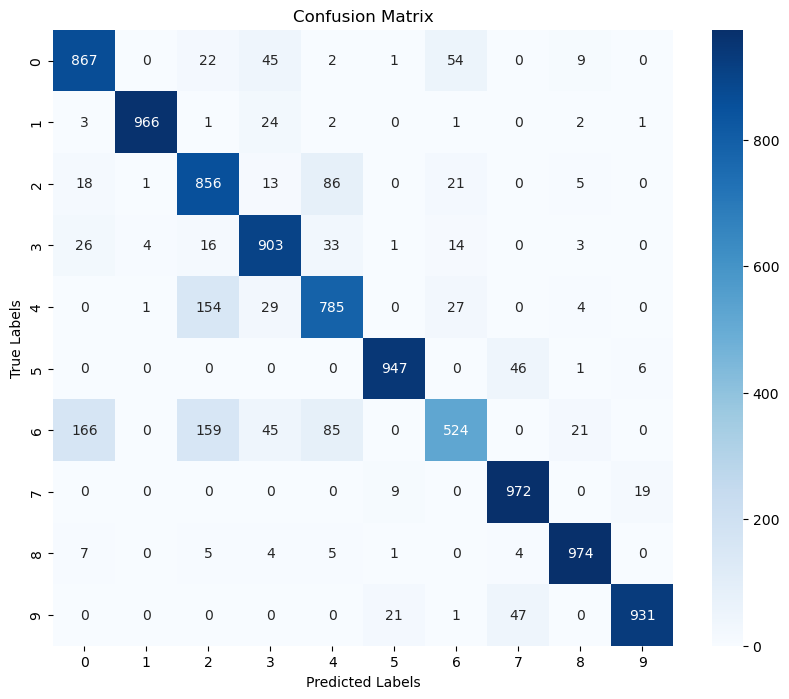

In [5]:
# Test seti üzerinde performans
test_loss, test_accuracy = best_model.evaluate(x_test_flat, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix ve Sınıflandırma Raporu
y_test_pred = np.argmax(best_model.predict(x_test_flat), axis=1)
y_test_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

# Sınıflandırma raporu
class_report = classification_report(y_test_true, y_test_pred)
print("\nClassification Report:\n", class_report)

# Confusion Matrix görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()